In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


# Proposed outline of work 

In [2]:
#RF giving me the score = 0.7732 (unoptimized/no grid search)
#grid search RF. = 0.77496
# Try KNN classifier=0.76638

#grid search logistic regression = 0.77012
    
# Optimize SVM grid search = 0.77012

# Try XGBoost classifier=0.76924(witout GS) now with GS = 0.77144 

# randomforest classifier=0.77

#SVC using GS = 0.77584

# Apply CART, Bagging and Boosting, and MLP.

#remove all zero ratings OR convert all zero ratings to 1 rating 
# try adding a value in null values in review column 

#yet to apply 
# since the variables are not normally distributed many  types of 
#varibale transformations( log, inverse,exponential,standard normal,etc) will be undertaken to improve the precision score.
# treating best score as dummy variable and interacting them with other continuous variables.

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'Logistic__C': 10, 'Logistic__max_iter': 500, 'Logistic__penalty': 'l2', 'Logistic__solver': 'saga', 'tfidf_vectorizer__max_df': 0.3, 'tfidf_vectorizer__ngram_range': (1, 2), 'tfidf_vectorizer__sublinear_tf': True}
Test Accuracy: 0.7873120645397873

# Importing the necessary libraries 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,make_scorer
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import re 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier




# LOADING THE DATASETS

In [4]:
df_train = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv")
#train set has 2 null values in recipe review column

In [5]:
df_test = pd.read_csv("/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv")
#test set has no null values 

In [6]:
df_train.shape

(13636, 15)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [8]:
df_train.head(5)

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


# EXPLORATORY DATA ANALYSIS

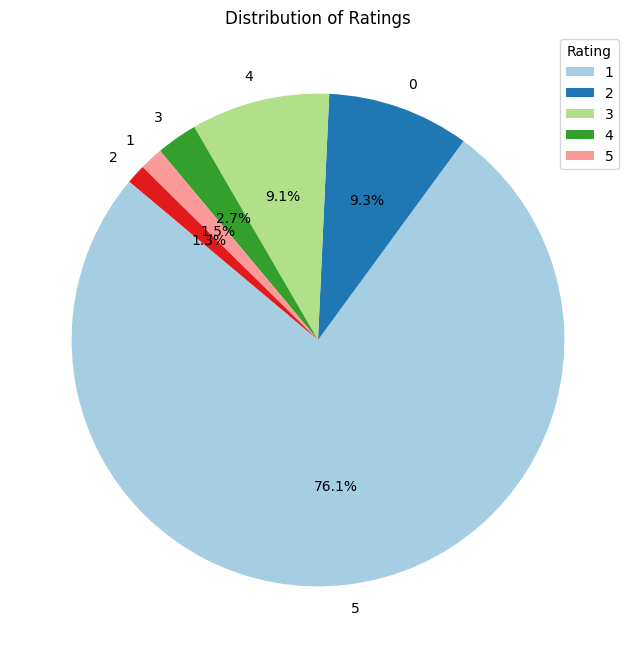

In [9]:
rating_counts = df_train['Rating'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Ratings')
plt.legend(title='Rating', loc='upper right', labels=['1', '2', '3', '4', '5'])
plt.show()

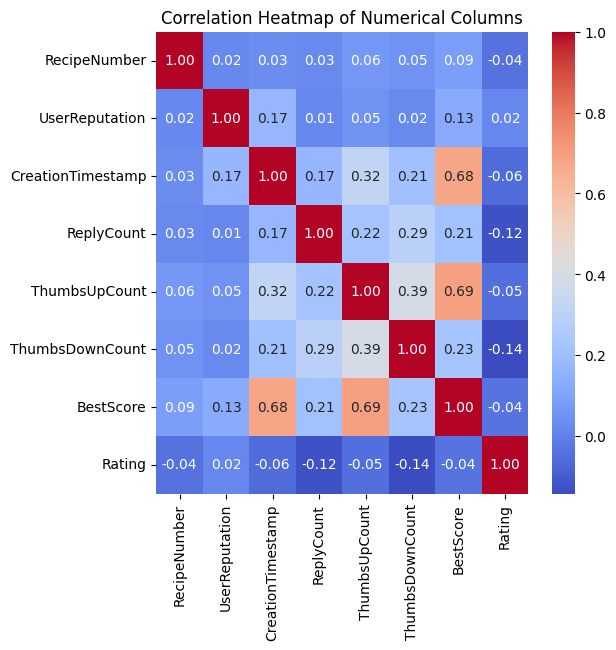

In [10]:
numerical_columns = ['RecipeNumber', 'UserReputation', 'CreationTimestamp', 
                     'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore','Rating']

# Create a DataFrame with only numerical columns
numerical_data = df_train[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Create the heatmap using Seaborn
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

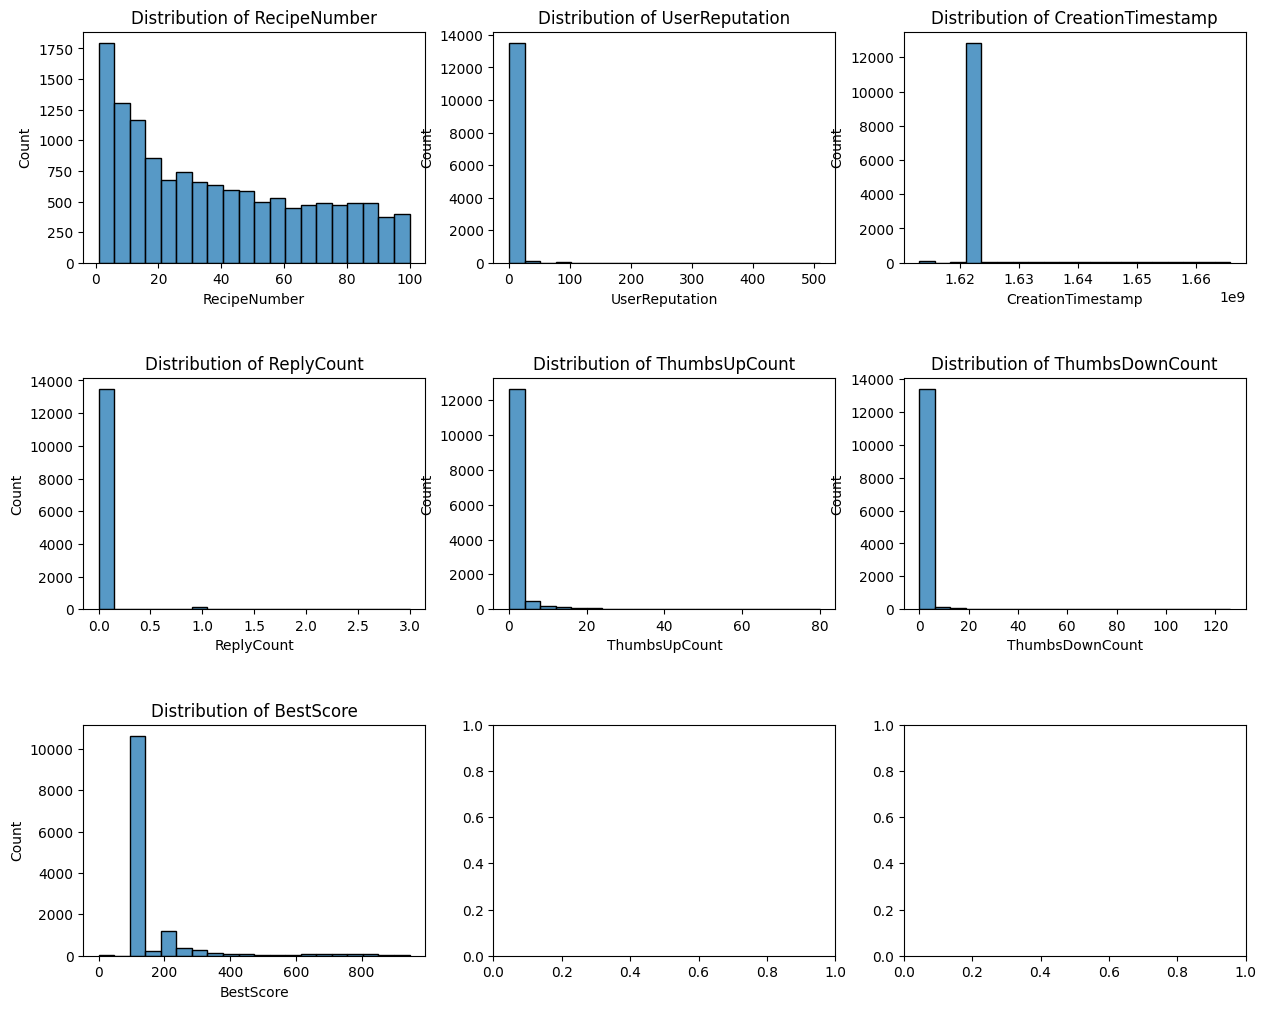

In [11]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.subplots_adjust(hspace=0.5)  

columns = ['RecipeNumber', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']

for i, column in enumerate(columns):
    row = i // 3
    col = i % 3
    sns.histplot(df_train[column], bins=20, kde=False, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {column}')

plt.show()

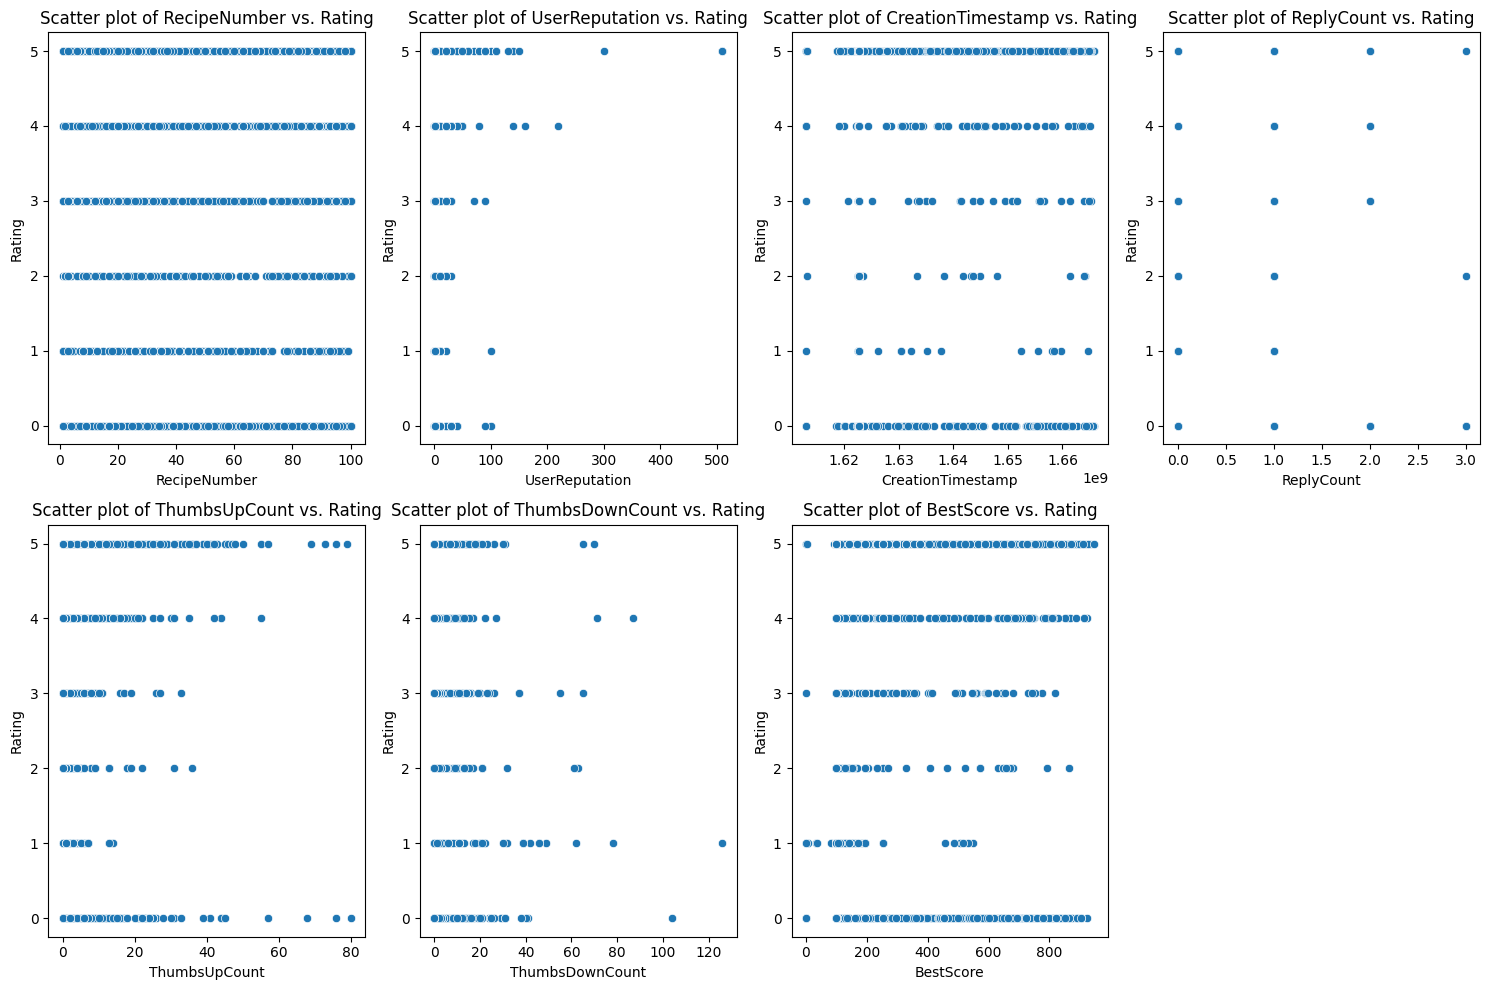

In [12]:
# Scatter plots
scatter_columns = ['RecipeNumber', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']

plt.figure(figsize=(15, 10))

for i, column in enumerate(scatter_columns):
    plt.subplot(2, 4, i + 1)
    sns.scatterplot(x=column, y='Rating', data=df_train)
    plt.title(f'Scatter plot of {column} vs. Rating')

plt.tight_layout()
plt.show()

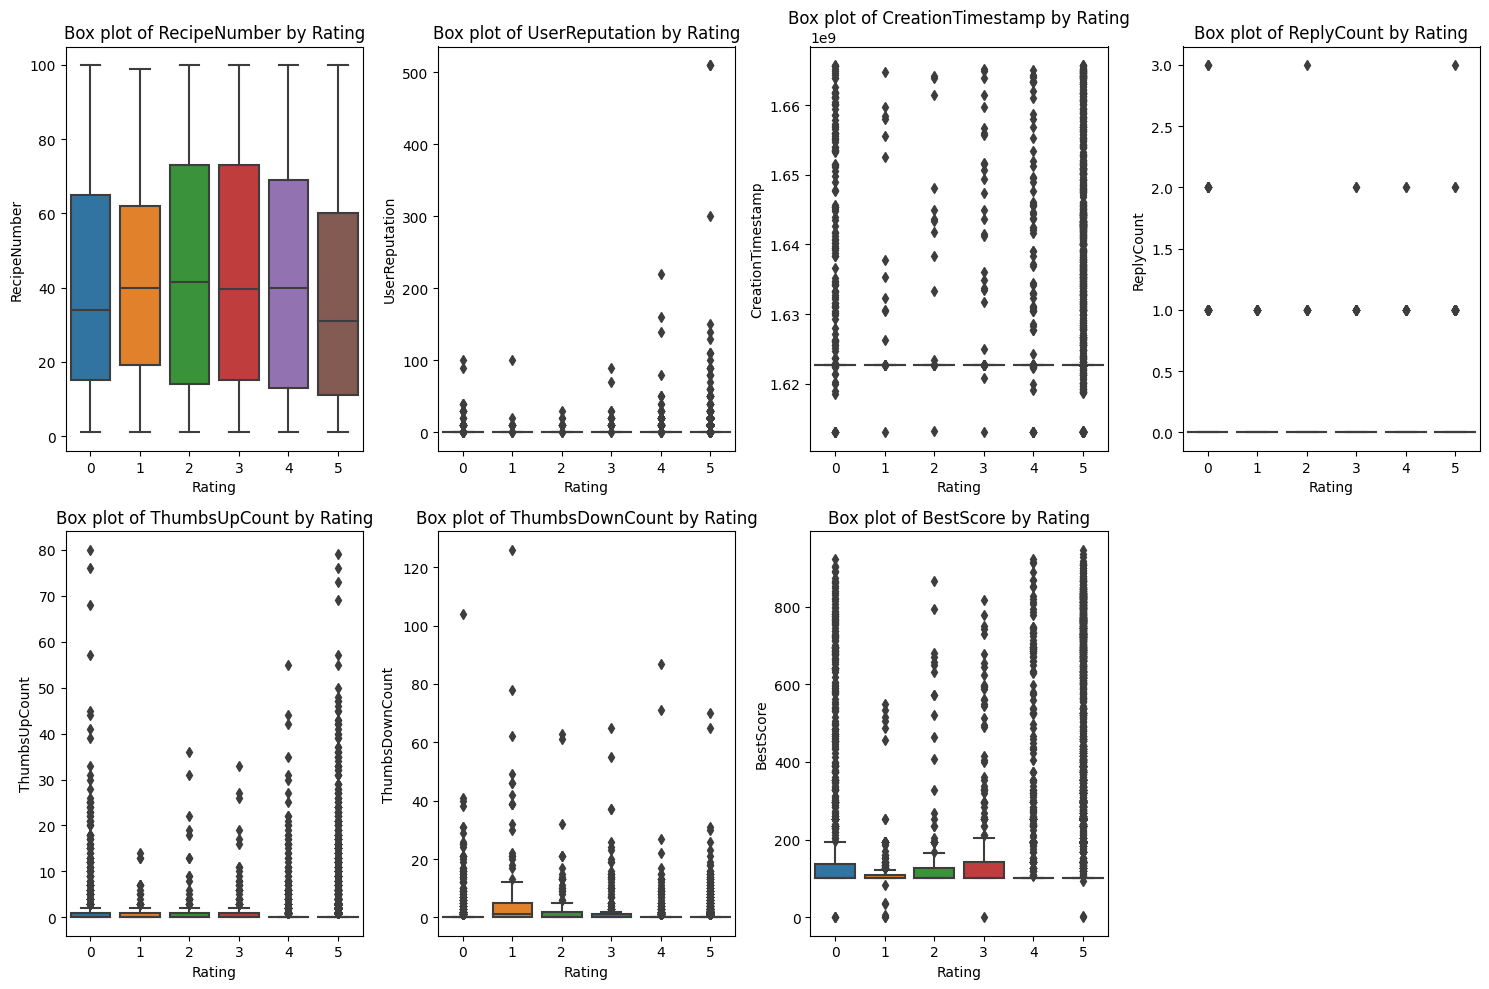

In [13]:
# Box plots
box_columns =  ['RecipeNumber', 'UserReputation', 'CreationTimestamp', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore']

plt.figure(figsize=(15, 10))

for i, column in enumerate(box_columns):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x='Rating', y=column, data=df_train)
    plt.title(f'Box plot of {column} by Rating')

plt.tight_layout()
plt.show()

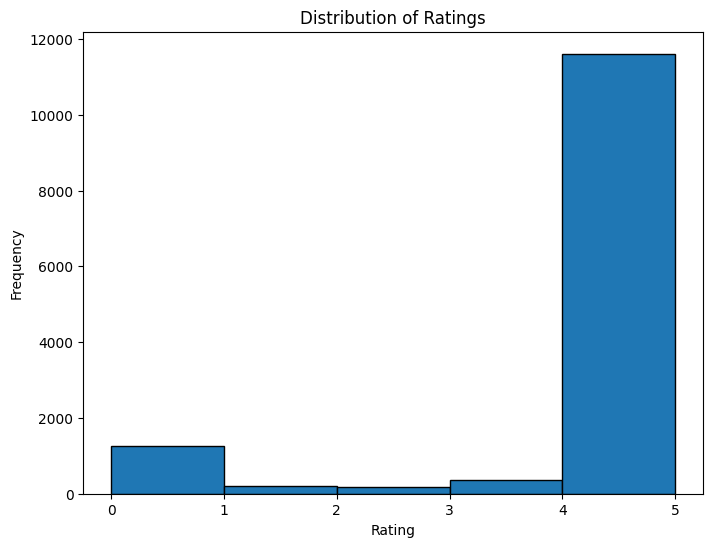

In [14]:

plt.figure(figsize=(8, 6))
plt.hist(df_train['Rating'], bins=5, edgecolor='black')  
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# FINDINGS FROM THE EDA 
            The target variable is left skewed, suggests for transformation
            The target variable's frequency distribution suggests skewness  to  the rating of  5 
 
            The target variable is weekly correlated to all the independent variables ( ref: to                       heat map/correlation matrix)
            Majority of the variables do not have normal distribution(ref:   
            histgram,boxplot,scatter plot).
            This leads to estimates not being precise. 
                

# Sentiment analysis for review column

In [15]:
#sentiment analysis
def analyze_sentiment(text):
    text=text.lower()
    
    positive_keywords = ['good', 'delicious', 'tasty', 'excellent']
    negative_keywords = ['bad', 'disappointing', 'awful', 'poor']

    if any(keyword in text for keyword in positive_keywords):
        return 'Positive'
    elif any(keyword in text for keyword in negative_keywords):
        return 'Negative'
    else:
        return 'Neutral'

# Preprocessing 

In [16]:
# Drop rows with missing values in the 'Recipe_Review' column
df_train = df_train.dropna(subset=['Recipe_Review'])
df_test = df_test.dropna(subset=['Recipe_Review'])

In [17]:
# Preprocess numerical columns
numerical_columns = ['ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount']
  


In [18]:
df_train[numerical_columns] = df_train[numerical_columns].fillna(0)  
df_test[numerical_columns] = df_test[numerical_columns].fillna(0)

In [19]:
# # Apply log transformation to handle skewness
# log_transformer = FunctionTransformer(np.log1p, validate=True)
# df_train[numerical_columns] = log_transformer.transform(df_train[numerical_columns])
# df_test[numerical_columns] = log_transformer.transform(df_test[numerical_columns])
# sqrt_transformer = FunctionTransformer(np.sqrt, validate=True)
# df_train[numerical_columns] = sqrt_transformer.transform(df_train[numerical_columns])
# df_test[numerical_columns] = sqrt_transformer.transform(df_test[numerical_columns])

In [20]:
# # Scale numerical columns
# scaler = StandardScaler()
# df_train[numerical_columns] = scaler.fit_transform(df_train[numerical_columns])
# df_test[numerical_columns] = scaler.transform(df_test[numerical_columns])

In [21]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.2, min_df=1, sublinear_tf=True)

In [22]:
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['Recipe_Review'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['Recipe_Review'])

In [23]:
# Apply sentiment analysis to the 'Recipe_Review' column
df_train['Sentiment'] = df_train['Recipe_Review'].apply(analyze_sentiment)
df_test['Sentiment'] = df_test['Recipe_Review'].apply(analyze_sentiment)

In [24]:

# Combine sentiment analysis with numerical features
X_train_sentiment = pd.get_dummies(df_train['Sentiment']).values
X_test_sentiment = pd.get_dummies(df_test['Sentiment']).values

In [25]:
# Combine sentiment analysis with numerical features and TF-IDF
X_train_combined = hstack([X_train_sentiment, X_train_tfidf, df_train[numerical_columns].values])
X_test_combined = hstack([X_test_sentiment, X_test_tfidf, df_test[numerical_columns].values])


# Spliting the dataset 

In [26]:
# Train-test split for combined data
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, df_train['Rating'], test_size=0.2, random_state=27)


# MODELS

# Applying Logistic Regression 

In [27]:
# model = LogisticRegression(penalty="l2",solver='saga',C=10,max_iter=500)
# model.fit(X_train, y_train)

# y_val_pred = model.predict(X_val)
# print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))

# y_test_pred_LR = model.predict(X_test_combined)
# df_test['Predicted_Rating'] = y_test_pred_LR

# applying XGB classifier 

In [28]:
# # Define XGBoost classifier with hyperparameters
# xgb_classifier = XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.1,subsample=0.8, n_jobs=-1)

# # Fit the classifier to the training data
# xgb_classifier.fit(X_train, y_train)

# # Make predictions on the validation set
# y_val_pred_xgb = xgb_classifier.predict(X_val)

# # Evaluate the model's performance
# accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
# print("Validation Accuracy with XGBoost:", accuracy_xgb)

# # Make predictions on the test set
# y_test_pred_xgb = xgb_classifier.predict(X_test_combined)
# df_test['Predicted_Rating_XGB'] = y_test_pred_xgb

# applying Linear_SVC

In [29]:
# # # Example with class_weight parameter in LinearSVC
# # weighted_linear_svc = LinearSVC(class_weight='balanced', penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# # weighted_linear_svc.fit(X_train, y_train)
# #getting 0.78511 and 0.7864 both's public score is getting 0.78794
# #now highest is 0.78731206

# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# linear_svc.fit(X_train, y_train)

# # Make predictions on the validation set
# y_val_pred = linear_svc.predict(X_val)
# accuracy = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy:", accuracy)

# # Make predictions on the test set
# y_test_pred = linear_svc.predict(X_test_combined)
# df_test['Predicted_Rating_LinearSVC'] = y_test_pred

# stacking classifier 

In [30]:
# from sklearn.ensemble import StackingClassifier
# #0.79454  giving me this when lr is meta classifier score on validation is  0.7906123945727906
# # Define the base classifiers
# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# xgb_classifier = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2, n_jobs=-1)

# # Define the meta-classifier
# meta_classifier = LogisticRegression()

# # Create the stacking classifier
# stacking_classifier = StackingClassifier(
#     estimators=[
#         ('linear_svc', linear_svc),
#         ('xgb_classifier', xgb_classifier)
#     ],
#     final_estimator=meta_classifier,
#     cv=5  # Number of folds for cross-validation
# )

# # Train the stacking classifier
# stacking_classifier.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = stacking_classifier.predict(X_test_combined)

# # Evaluate predictions on validation set
# y_pred_val = stacking_classifier.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred_val)
# print("Weighted Average Accuracy:", accuracy)

In [31]:
# Define the base classifiers
linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
xgb_classifier = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2, n_jobs=-1)

# Define the meta-classifiers
meta_classifiers = [
    ('DecisionTree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(100,), max_iter=200))
]

for name, meta_classifier in meta_classifiers:
    # Create the stacking classifier with each meta-classifier
    stacking_classifier = StackingClassifier(
        estimators=[
            ('linear_svc', linear_svc),
            ('xgb_classifier', xgb_classifier)
        ],
        final_estimator=meta_classifier,
        cv=5  # Number of folds for cross-validation
    )

    # Train the stacking classifier
    stacking_classifier.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred_val = stacking_classifier.predict(X_val)

    # Evaluate predictions on the validation set
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Meta-Classifier: {name}, Validation Accuracy: {accuracy}")

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Meta-Classifier: DecisionTree, Validation Accuracy: 0.6813348001466814


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Meta-Classifier: RandomForest, Validation Accuracy: 0.7865786578657866


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Meta-Classifier: GradientBoosting, Validation Accuracy: 0.7851118445177852


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Meta-Classifier: SVM, Validation Accuracy: 0.7851118445177852


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Meta-Classifier: NeuralNetwork, Validation Accuracy: 0.7939127246057939


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [32]:
# Make predictions on the test set
y_pred = stacking_classifier.predict(X_test_combined)

# Tring something else 

In [33]:
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import StackingClassifier
# from sklearn.metrics import accuracy_score

# # Define the base classifiers
# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# xgb_classifier = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2, n_jobs=-1)

# # Define the meta-classifiers
# meta_classifiers = [
#     ('NeuralNetwork', MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)),
#     ('GradientBoosting', XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1))
# ]

# for name, meta_classifier in meta_classifiers:
#     # Create the stacking classifier with each meta-classifier
#     stacking_classifier = StackingClassifier(
#         estimators=[
#             ('linear_svc', linear_svc),
#             ('xgb_classifier', xgb_classifier)
#         ],
#         final_estimator=meta_classifier,
#         cv=5  # Number of folds for cross-validation
#     )

#     # Train the stacking classifier
#     stacking_classifier.fit(X_train, y_train)

#     # Make predictions on the validation set
#     y_pred_val = stacking_classifier.predict(X_val)

#     # Evaluate predictions on the validation set
#     accuracy = accuracy_score(y_val, y_pred_val)
#     print(f"Meta-Classifier: {name}, Validation Accuracy: {accuracy}") 

In [34]:
# # Make predictions on the test set
# y_pred = stacking_classifier.predict(X_test_combined)

# trying error analysis 

In [35]:
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score
# import numpy as np

# # Define the base classifiers
# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# xgb_classifier = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2, n_jobs=-1)

# # Define the meta-classifiers
# meta_classifiers = [
#     ('DecisionTree', DecisionTreeClassifier()),
#     ('RandomForest', RandomForestClassifier()),
#     ('GradientBoosting', GradientBoostingClassifier()),
#     ('NeuralNetwork', MLPClassifier())
# ]

# # Train and evaluate stacking classifier with different meta-classifiers
# for name, meta_classifier in meta_classifiers:
#     # Create the stacking classifier with each meta-classifier
#     stacking_classifier = StackingClassifier(
#         estimators=[
#             ('linear_svc', linear_svc),
#             ('xgb_classifier', xgb_classifier)
#         ],
#         final_estimator=meta_classifier,
#         cv=5  # Number of folds for cross-validation
#     )

#     # Train the stacking classifier
#     stacking_classifier.fit(X_train, y_train)

#     # Make predictions on the validation set
#     y_pred_val = stacking_classifier.predict(X_val)

#     # Evaluate predictions on the validation set
#     accuracy = accuracy_score(y_val, y_pred_val)
#     print(f"Meta-Classifier: {name}, Validation Accuracy: {accuracy}")

#     # Error Analysis
#     # Analyze misclassified instances on validation set
#     misclassified_indices = np.where(y_val != y_pred_val)[0]
#     misclassified_samples = X_val[misclassified_indices]
#     true_labels = y_val[misclassified_indices]
#     predicted_labels = y_pred_val[misclassified_indices]

#     # Print misclassified instances and their true/predicted labels
#     print("Misclassified Instances:")
#     for i in range(len(misclassified_indices)):
#         print(f"Sample: {misclassified_samples[i]}, True Label: {true_labels[i]}, Predicted Label: {predicted_labels[i]}")

#     # Model Interpretability
#     # Analyze feature importances for base classifiers and meta-classifier
#     linear_svc_feature_importance = linear_svc.coef_
#     xgb_feature_importance = xgb_classifier.feature_importances_
#     meta_classifier_feature_importance = stacking_classifier.final_estimator_.feature_importances_

#     # Print feature importances
#     print("Linear SVC Feature Importance:", linear_svc_feature_importance)
#     print("XGBoost Feature Importance:", xgb_feature_importance)
#     print(f"{name} Meta-Classifier Feature Importance:", meta_classifier_feature_importance)

# voting ensemble for three models

In [36]:
# #0.78926 aslo highest without Logistic regression
# # Define individual classifiers
# # logistic_regression = LogisticRegression(penalty='l2', C=1, fit_intercept=True, max_iter=1000)
# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', tol=0.01, C=1, fit_intercept=True, max_iter=1000, dual=True)
# xgb_classifier = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.2, n_jobs=-1)

# # Create a Voting Classifier
# voting_classifier = VotingClassifier(estimators=[
#     ('linearsvc', linear_svc),
#     ('xgbclassifier',xgb_classifier)
# ], voting='hard')

# # Train the Voting Classifier
# voting_classifier.fit(X_train,y_train)

# # Make predictions on the test set
# y_pred = voting_classifier.predict(X_test_combined) # this is for submission.csv

# # Evaluate predictions on validation set
# y_pred_val=voting_classifier.predict(X_val)
# accuracy = accuracy_score(y_val, y_pred_val)
# print("Weighted Average Accuracy:", accuracy)

In [37]:
# # Define the parameter grid
# param_grid = {
#     'C': [1, 10],  
#     'tol': [0.01, 0.1],  
#     'max_iter': [1000, 1500]  
# }

# # Create a LinearSVC model
# linear_svc = LinearSVC(penalty='l2', loss='squared_hinge', fit_intercept=True, dual=True)

# # Create GridSearchCV object
# grid_search = GridSearchCV(linear_svc, param_grid, cv=3, scoring='accuracy')

# # Fit the model with the training data
# grid_search.fit(X_train, y_train)

# # Get the best parameters from the grid search
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # validation set with the best model
# best_model = grid_search.best_estimator_
# y_val_pred = best_model.predict(X_val)
# accuracy = accuracy_score(y_val, y_val_pred)
# print("Validation Accuracy with Best Model:", accuracy)

# # test set with the best model
# y_test_pred = best_model.predict(X_test_combined)
# df_test['Predicted_Rating_LinearSVC_GridSearch'] = y_test_pred

# AUC-ROC curve for Linear SVC model

In [38]:
# # Binarize the target variable for multi-class classification
# y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4, 5])

# # Get predicted probabilities for each class
# y_val_scores = linear_svc.decision_function(X_val) 

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(len(df_train['Rating'].unique())):
#     fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_scores[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])



In [39]:
# # Plot ROC curve for each class
# plt.figure(figsize=(7, 7))
# colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
# for i, color in zip(range(len(df_train['Rating'].unique())), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = {:.2f}) for Rating {}'.format(roc_auc[i], i))

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
# plt.legend(loc='lower right')
# plt.show()

# applying RandomForest Classifier

In [40]:
# rf_classifier = RandomForestClassifier(random_state=42)

# # Define a smaller set of hyperparameters to search
# param_grid_rf = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 10],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }


In [41]:
# # Use GridSearchCV for hyperparameter tuning
# grid_search_rf = GridSearchCV(rf_classifier, param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters for Random Forest:", grid_search_rf.best_params_)

In [42]:
# # Get the best Random Forest model
# best_rf_model = grid_search_rf.best_estimator_

In [43]:
# # Make predictions on the validation set
# y_val_pred_rf = best_rf_model.predict(X_val)
# accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
# print("Validation Accuracy with Random Forest:", accuracy_rf)

# # Make predictions on the test set
# y_test_pred_rf = best_rf_model.predict(X_test_combined)
# df_test['Predicted_Rating_RF'] = y_test_pred_rf


# Applying KNN Classifier

In [44]:
# # Define the KNN classifier
# knn_classifier = KNeighborsClassifier()

# # Create a pipeline
# pipeline = Pipeline([
#     ('knn', knn_classifier)
# ])

# # Define hyperparameters to search
# param_grid = {
#     'knn__n_neighbors': [3, 7, 10],
#     'knn__weights': ['uniform', 'distance'],
#     'knn__p': [1, 2]
# }

# # Use GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters
# print("Best Hyperparameters:", grid_search.best_params_)

# # Get the best KNN model
# best_knn_model = grid_search.best_estimator_

# # Make predictions on the validation set
# y_val_pred_knn = best_knn_model.predict(X_val)
# accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
# print("Validation Accuracy with KNN:", accuracy_knn)

In [45]:
# # Make predictions on the test set
# y_test_pred_knn = best_knn_model.predict(X_test_combined)
# df_test['Predicted_Rating_KNN'] = y_test_pred_knn

In [46]:
# # Best hyperparameters from the grid search
# best_hyperparameters = {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

# # Create a new KNN model with the best hyperparameters
# best_knn_model = KNeighborsClassifier(**best_hyperparameters)

# # Fit the model on the training data
# best_knn_model.fit(X_train, y_train)

# # Make predictions on the validation set
# y_val_pred_knn = best_knn_model.predict(X_val)
# accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
# print("Validation Accuracy with KNN:", accuracy_knn)

# # Make predictions on the test set
# y_test_pred_knn = best_knn_model.predict(X_test_combined)
# df_test['Predicted_Rating_KNN'] = y_test_pred_knn


# Model Comparision between Linear SVC and KNN classifier 

In [47]:
# # Evaluate LinearSVC
# print("LinearSVC Model Evaluation:")
# print("Validation Accuracy:", accuracy)
# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_val_pred))
# print("Classification Report:")
# print(classification_report(y_val, y_val_pred))



In [48]:
# # Evaluate KNN
# print("\nKNN Model Evaluation:")
# print("Validation Accuracy with KNN:", accuracy_knn)
# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_val_pred_knn)) 
# print("Classification Report:")
# print(classification_report(y_val, y_val_pred_knn))

# Accuracy table 

In [49]:
model_names = ['LinearSVC', 'Random Forest', 'KNN']
accuracy_values = [0.7886,0.7700 , 0.7704]

# Create a DataFrame
accuracy_table = pd.DataFrame({'Model': model_names, 'Validation Accuracy': accuracy_values})

# Print the accuracy table
print(accuracy_table)

           Model  Validation Accuracy
0      LinearSVC               0.7886
1  Random Forest               0.7700
2            KNN               0.7704


# writing the prediction to submission.csv file

In [50]:
# Create a DataFrame with 'id' values ranging from 1 to 4546 and corresponding predicted ratings
submission_df = pd.DataFrame({'ID': range(1, 4547), 'Rating': y_pred})

# Write predictions to submission.csv
submission_df.to_csv('submission.csv', index=False)